# Image Detection

In [ ]:
# 코랩과 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요 모듈 설치
!pip install keras-cv
!pip install keras
!pip install h5py

In [ ]:
# 필요 모듈 IMPORT
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile
from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from keras.models import load_model
from PIL import Image

In [ ]:
# Hyperparameter 설정
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCH = 20
GLOBAL_CLIPNORM = 10.0

In [ ]:
#class 이름 p:person, t: text
class_ids = [
    "p",
    "t"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# 이미지와 어노테이션 경로 설정
path_images = '/content/drive/MyDrive/3_1_data/xml/images'
path_annot = '/content/drive/MyDrive/3_1_data/xml/anotations'

# 어노테이션 경로 안에 있는.XML 확장자 파일의 경로를 리스트로 합침
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# 이미지 경로 안에 있는 .jpeg 확장자 파일의 경로를 리스트로 합침
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [ ]:
# xml 확장자 파일 안에 있는 어노테이션을 분석하는 함수
# 함수 결과로 image_path, boxes, class_ids반환
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    # 파일 속 object 항목을 불러옴
    # object에 있는 클래스(p 혹은 t) 이름, 바운딩 박스 좌표 확인
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    # class_id 로 반환

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []

# parse_annotation 함수 결과를 각각의 image_path, boxes, class_ids로 반환
# 이미지 경로, 바운딩 박스 경로, class명을 리스트에 추가
# 해당 활동의 진행률을 프로세스 바로 표현

for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/2986 [00:00<?, ?it/s]

In [ ]:
# 바운딩 박스, 클래스, 이미지 경로를 각각 알맞게 분할
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)


#각각의 내용들을 데이터셋으로 만들기
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [ ]:
# validation 샘플 개수 체크 (전체 데이터셋에서 8:2로 나눌 예정)
num_val = int(len(xml_files) * SPLIT_RATIO)

# train 및 validation 분할 (validation data를 먼저 나누고 이외의 것을 train data로)
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [ ]:
# 이미지 load 함수 > tensor data 로
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

# 데이터셋 로드 함수 이미지 경로, 클래스, 바운딩 박스값
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    print(tf.cast(image, tf.float32))
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

# train에 사용할 데이터 증강 및 이미지 크기 조절
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",
        ),
    ]
)

# train dataset 생성()
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

Tensor("Cast_1:0", shape=(None, None, 3), dtype=float32)


In [ ]:
# validation dataset에 사용할 resize 값
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

# validation dataset 생성
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

Tensor("Cast_1:0", shape=(None, None, 3), dtype=float32)


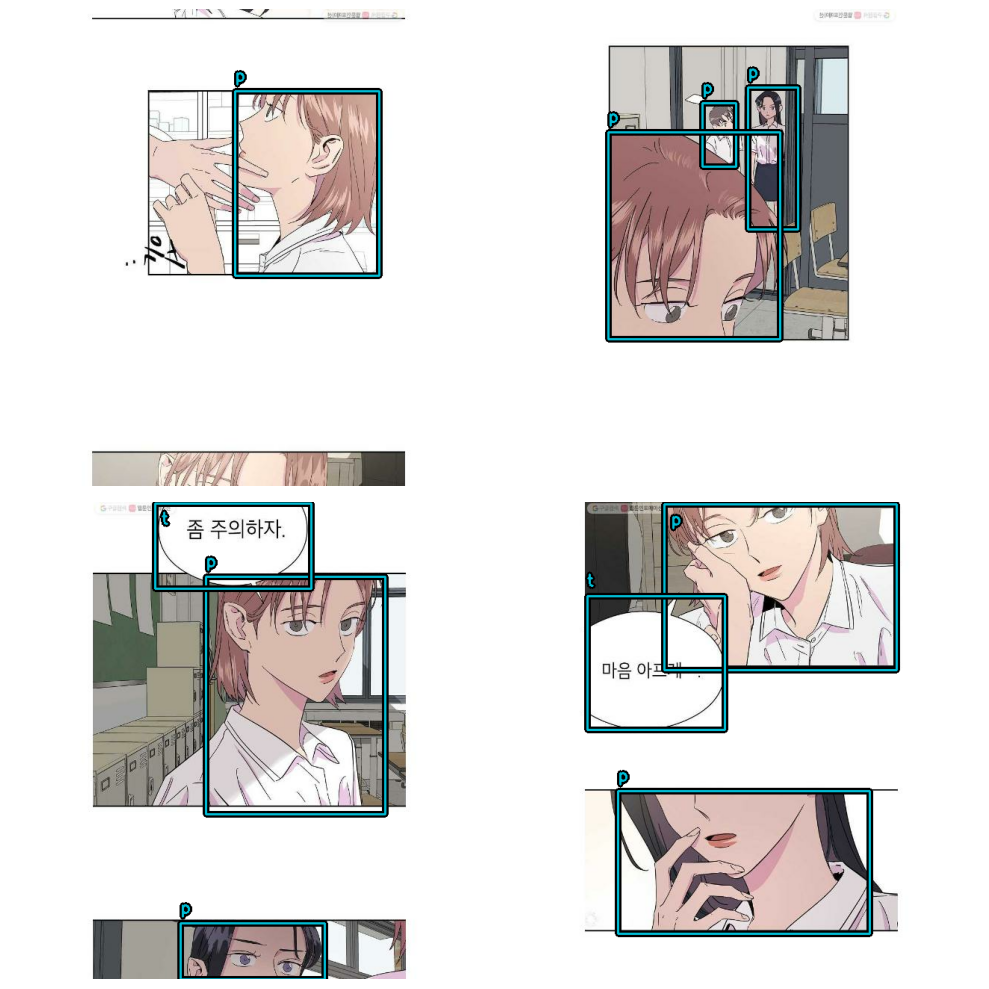

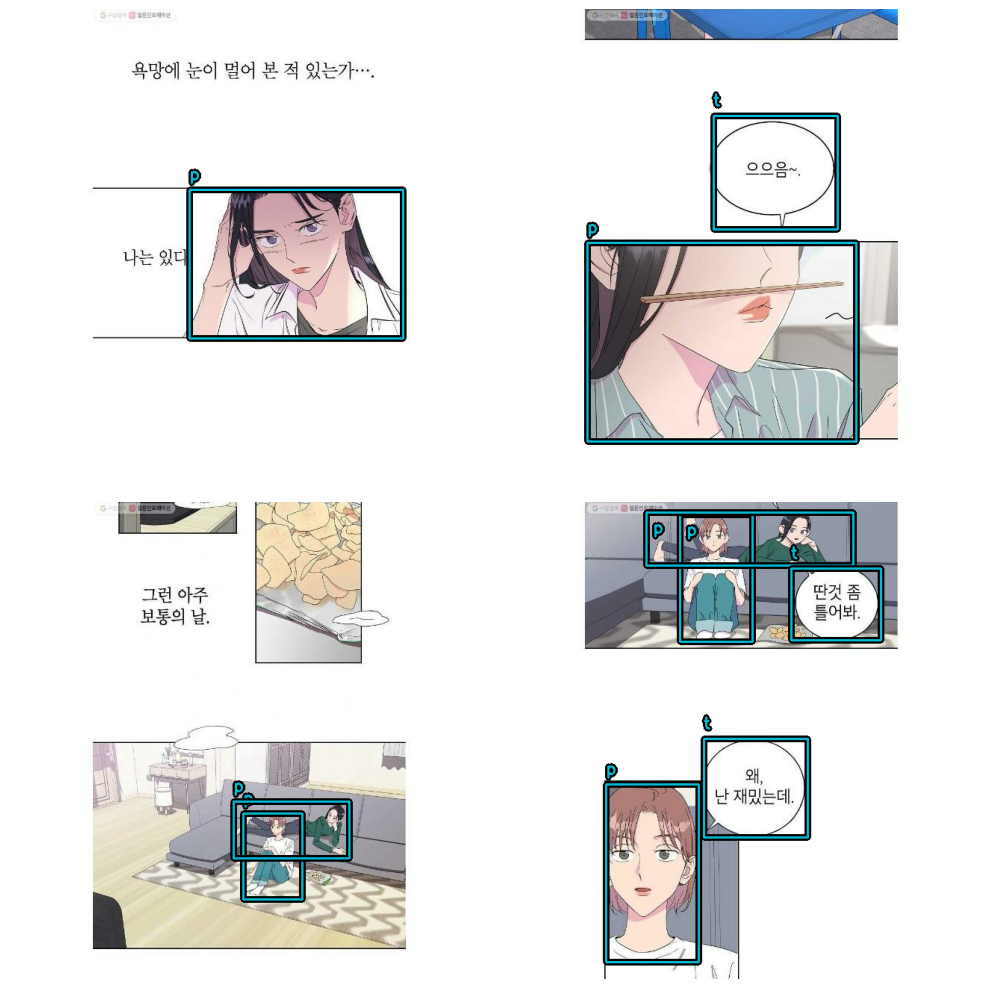

In [ ]:
# data 시각화 함수
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

# train_data 시각화
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

# validation_data 시각화
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# backbone yolo_v8_backbone_coco 사용
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)
# yolo model 생성
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)
# yolo model summary
yolo.summary()

In [ ]:
# optimizer 설정
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

# 모델 컴파일
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
# gpu 사용 모델 학습
with tf.device('/device:GPU:0'):
  history = yolo.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCH,
  )

Epoch 1/20
298/298 [==============================] - 310s 804ms/step - loss: 25.2060 - box_loss: 2.3113 - class_loss: 22.8947 - val_loss: 4.4707 - val_box_loss: 2.5782 - val_class_loss: 1.8924
Epoch 2/20
298/298 [==============================] - 119s 397ms/step - loss: 3.4449 - box_loss: 2.1313 - class_loss: 1.3136 - val_loss: 4.5301 - val_box_loss: 2.5017 - val_class_loss: 2.0283
Epoch 3/20
298/298 [==============================] - 119s 398ms/step - loss: 3.1446 - box_loss: 1.9821 - class_loss: 1.1625 - val_loss: 4.7297 - val_box_loss: 2.7353 - val_class_loss: 1.9944
Epoch 4/20
298/298 [==============================] - 120s 398ms/step - loss: 2.9684 - box_loss: 1.9019 - class_loss: 1.0665 - val_loss: 3.9621 - val_box_loss: 2.4620 - val_class_loss: 1.5001
Epoch 5/20
298/298 [==============================] - 120s 398ms/step - loss: 2.8489 - box_loss: 1.8468 - class_loss: 1.0021 - val_loss: 4.4806 - val_box_loss: 2.5974 - val_class_loss: 1.8832
Epoch 6/20
298/298 [==================

1/1 [==============================] - 0s 246ms/step


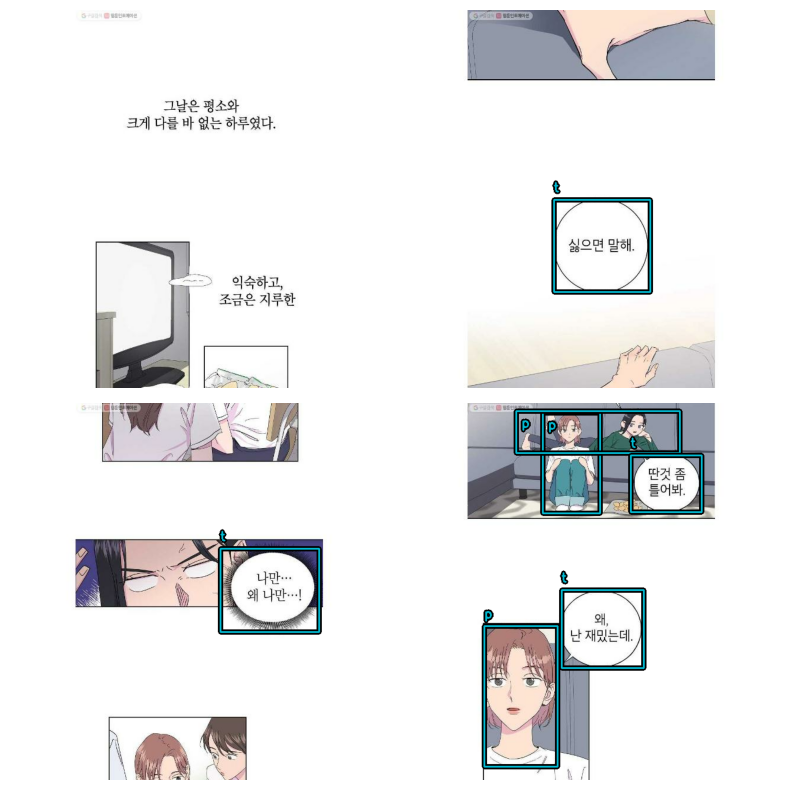

1/1 [==============================] - 0s 229ms/step


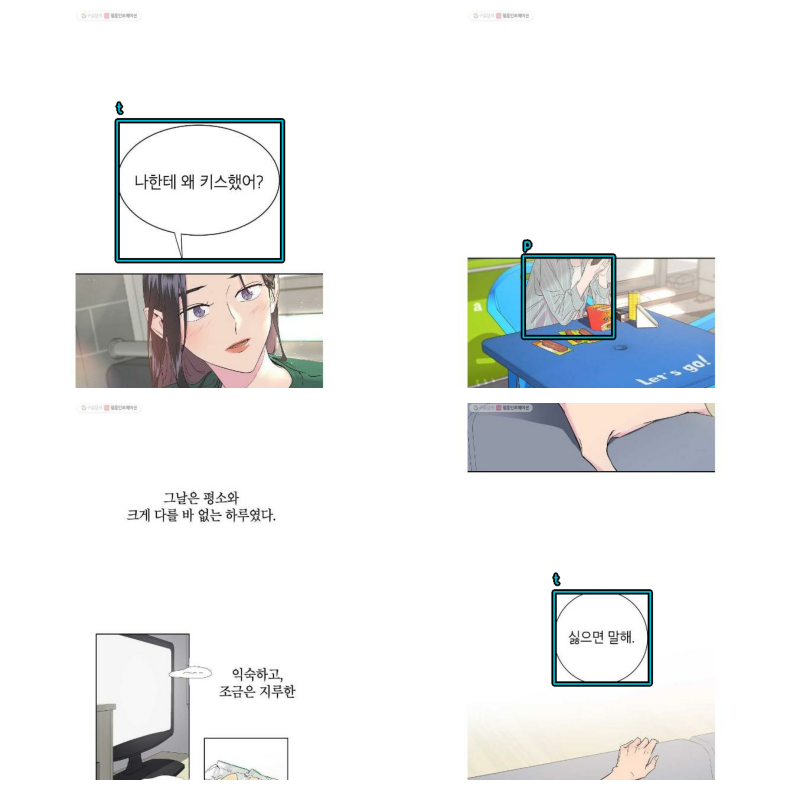

1/1 [==============================] - 0s 244ms/step


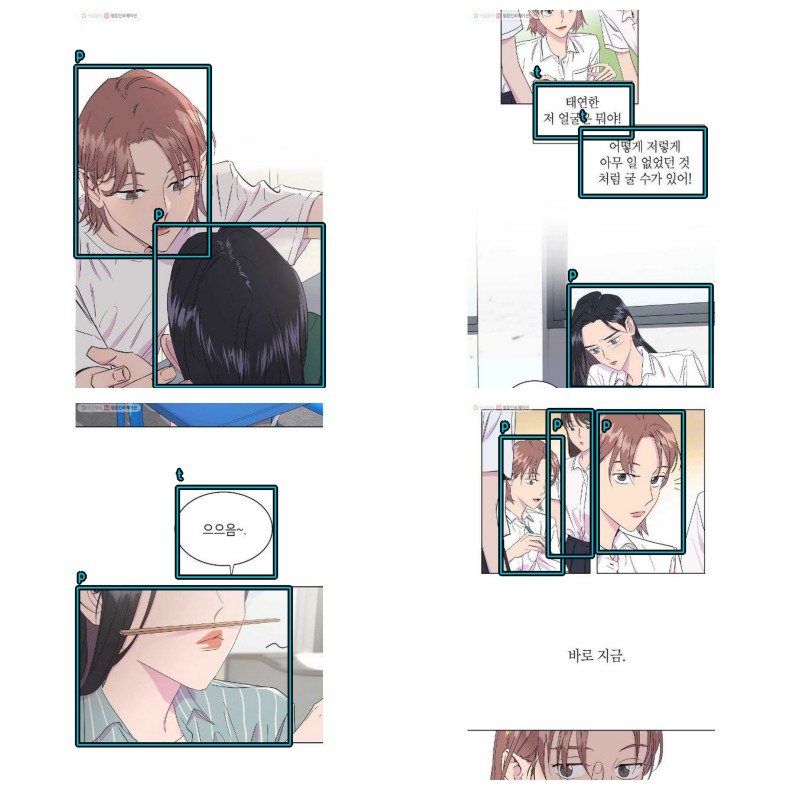

1/1 [==============================] - 0s 226ms/step


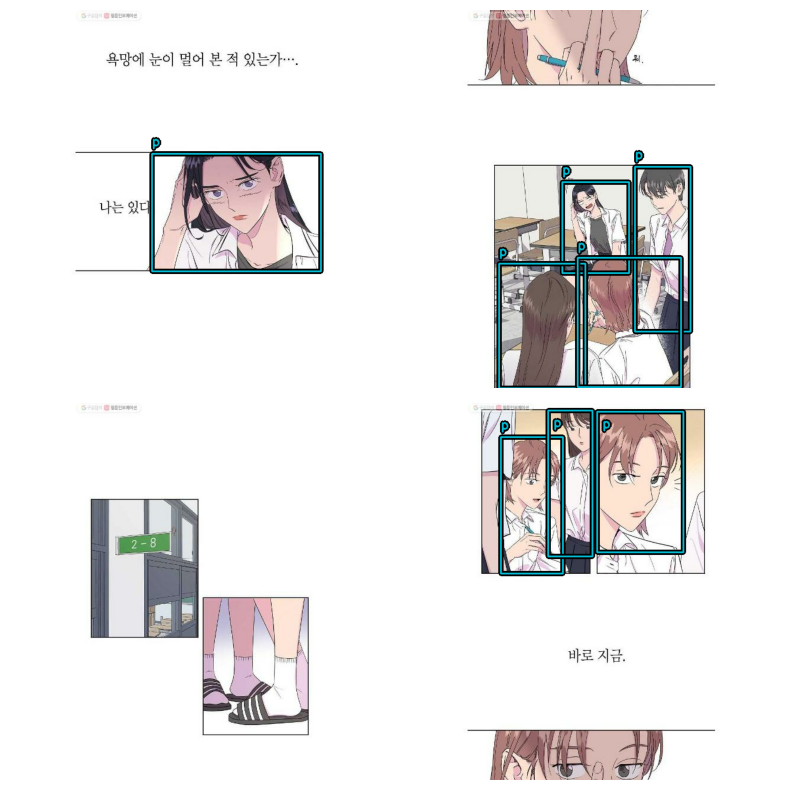

1/1 [==============================] - 0s 225ms/step


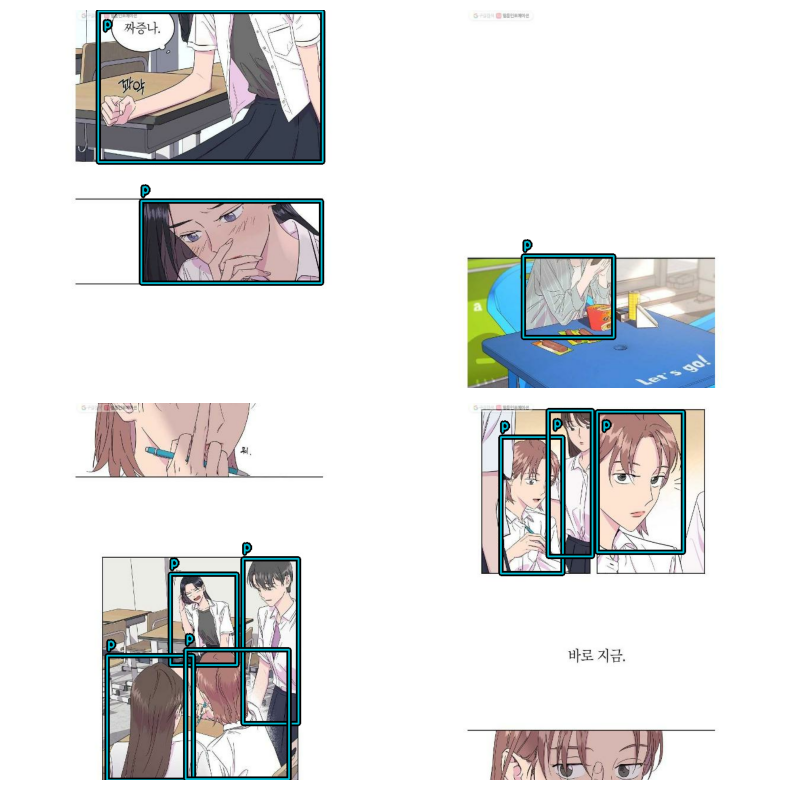

In [ ]:
# prediction 시각화 함수
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(5):
        x = next(iter(dataset.take(i+1)))
        images = x['images']
        y_true = x['bounding_boxes']
        y_pred = model.predict(images)
        y_pred = bounding_box.to_ragged(y_pred)
        visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            y_true=y_true,
            #y_pred=y_pred,
            scale=4,
            rows=2,
            cols=2,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")


# Image Classification
# ConvNeXtBase / augO / 6:2:2 / sigmoid activation / binarycrossentropy / lr0.0001 / batch 64 / epoch 20

In [ ]:
# 필요 모듈 설치
!pip install split-folders

In [ ]:
# 필요 모듈 import
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ConvNeXtBase
import pandas as pd
from tensorflow.python.client import device_lib
import os
import splitfolders
from PIL import Image

In [ ]:
# 구글 코랩 드라이브와 마운트
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 입력 폴더 경로
input_folder = '/content/drive/MyDrive/dataset'  # 이미지 데이터가 있는 폴더 경로

# 출력 폴더 경로 설정 및 분할 비율 설정
output_folder = '/content/drive/MyDrive/dataset_output'  # 분할된 데이터가 저장될 폴더 경로

# 데이터 폴더 별로 분할
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.6, 0.2, 0.2))

In [ ]:
data_dir = '/content/drive/MyDrive/3_1_data/7_2_1'# train, val, test가 저장된 아웃풋 데이터 경로
train_dir = data_dir + '/train'  # train data 경로
val_dir = data_dir + '/val' # validation data 경로
test_dir = data_dir + '/test' # test data 경로

In [ ]:
# 이미지 전처리 : 수평 augmentation, 정규화
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    horizontal_flip=True)

In [ ]:
# train_dataset 생성
train_ds = img_gen.flow_from_directory(directory=train_dir,
                                       target_size=(224, 224),
                                       class_mode='binary',
                                       color_mode='rgb',
                                       subset='training',
                                       batch_size=64)

In [ ]:
# validation_dataset 생성
val_ds = img_gen.flow_from_directory(directory=val_dir,
                                     target_size=(224,224),
                                     class_mode='binary',
                                     color_mode='rgb',
                                     subset='training',
                                     batch_size=64)

In [ ]:
# test_dataset 생성
test_ds = img_gen.flow_from_directory(directory=test_dir,
                                     target_size=(224,224),
                                     class_mode='binary',
                                     color_mode='rgb',
                                     subset='training',
                                     batch_size=64)

In [ ]:
# Convnext model 불러오기
preprocess_input = tf.keras.applications.convnext.preprocess_input

# Convnext model 생성
ConBase_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

ConBase_model.trainable = False #모델model freeszing (Dense만 사용하게끔!)

In [ ]:
# 추가 레이어
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer1 = layers.Dense(128, activation='relu')
prediction_layer2 = layers.Dense(1, activation='sigmoid')

In [ ]:
# 최종 모델 생성
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = ConBase_model(x, training=False) # 위에서 설정한 모델명 변수명을 넣을 것
x = global_average_layer(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
lr = 0.0001

# 손실 함수 설정
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
# 모델 요약 확인
model.summary()

In [ ]:
#모델 학습
with tf.device('/device:GPU:0'):
  history = model.fit(train_ds, epochs=20,
                      validation_data=val_ds)

In [ ]:
# 학습 결과 저장
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1.0)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,1)
plt.show()

In [ ]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

In [ ]:
# 표로 확인
pd.DataFrame(history.history)

In [ ]:
# 한 번에 시각화
t=pd.DataFrame(history.history)
t.plot()

# TEXT Classification

In [ ]:
pip install easyocr

In [ ]:
!pip install py-hanspell

In [ ]:
import easyocr
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import re
from hanspell import spell_checker

In [ ]:
#이미지 경로 설정
image_path = '경로를 넣어주세요'

In [ ]:
def extract_text_exclude_balloon(image_path):
    image = cv2.imread(image_path)
    reader = easyocr.Reader(['ko', 'en'])

    # 이미지를 그레이스케일로 변환.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 이미지의 Contrast를 향상시키기 위해 CLAHE를 적용.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(gray)

    # 이미지에 가우시안 블러를 적용하여 노이즈를 줄임.
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 이미지 이진화.
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 이미지 모폴로지 연산을 적용.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # 이미지 팽창 연산을 적용.
    dilation = cv2.dilate(binary, kernel, iterations=1)

    # 이미지 침식 연산을 적용.
    erosion = cv2.erode(dilation, kernel, iterations=1)

    # 이미지 텍스트를 읽어옴.
    results = reader.readtext(morph,decoder='beamsearch')

    # 이미지와 같은 크기의 마스크를 생성.
    mask = np.zeros_like(image)

    # 추출한 텍스트의 경계 상자를 마스크에 채움.
    for (bbox, text, prob) in results:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        pts = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)
        cv2.fillPoly(mask, [pts], (255, 255, 255))

    # 원본 이미지와 마스크를 AND 연산하여 결과 이미지를 생성.
    result_image = cv2.bitwise_and(image, mask)

    # 결과 이미지에서 텍스트를 다시 읽어옴.
    results_after_fillPoly = reader.readtext(result_image)

    # 텍스트를 정제하여 결과 리스트에 추가.
    result_texts = []
    for (bbox, text, prob) in results_after_fillPoly:
        clean_text = re.sub(r'[^가-힣]', '', text)
        result_texts.append(clean_text)

    # 결과 리스트 반환.
    return result_texts

In [ ]:
extract_text_exclude_balloon(image_path)

In [ ]:
results = extract_text_exclude_balloon(image_path)
print(results)

In [ ]:
# 올바르게 수정된 텍스트들을 저장할 리스트 생성.
corrected_texts = []

for text in results:
    # spell_checker를 이용해 텍스트의 맞춤법을 확인.
    result = spell_checker.check(text)
    corrected_text = result.checked
    corrected_texts.append(corrected_text)

print(corrected_texts)

In [ ]:
!pip install torch
!pip install transformers

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from transformers import BertTokenizerFast
import torch.nn as nn
import random
import os
import torch.nn.functional as F

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
def load_data(file_path):
    # 빈 리스트를 생성. 이곳에 텍스트와 레이블을 저장.
    texts = []
    labels = []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

        # 각 라인에 대해서 실행합니다.
        for line in lines:
            # strip() 함수로 양쪽 공백을 제거하고, '|' 기호를 기준으로 텍스트와 레이블을 분리.
            text, label = line.strip().split('|')
            texts.append(text)
            labels.append(int(label))

    return texts, labels

sexual_texts, sexual_labels = load_data('/content/sexualtexts.txt')
normal_texts, normal_labels = load_data('/content/normaltexts.txt')

In [ ]:
def load_and_sample_data(filepath, sample_size):
    texts, labels = load_data(filepath)
    data = list(zip(texts, labels))
    data = random.sample(data, sample_size)
    texts, labels = zip(*data)
    return texts, labels

sexual_texts, sexual_labels = load_and_sample_data('/content/sexualtexts.txt', 10000)
normal_texts, normal_labels = load_and_sample_data('/content/normaltexts.txt', 10000)

texts = sexual_texts + normal_texts
labels = sexual_labels + normal_labels

In [ ]:
class TextDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

        # BERT의 토크나이저를 로드.
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        # 인코딩된 입력과 레이블을 딕셔너리 형태로 반환.
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 훈련 데이터와 검증 데이터로 분리.
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# 훈련 데이터셋과 검증 데이터셋 생성
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)

In [ ]:
# 배치 크기를 설정.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 레이블의 개수 설정.
num_labels = 2
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_labels)

In [ ]:
# 손실 함수 설정.
loss_fn = nn.BCEWithLogitsLoss()

# 옵티마이저 설정.
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
# 사용 가능한 CUDA GPU가 있으면 그것을 사용하고, 없으면 CPU를 사용.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델을 지정된 하드웨어에 배치.
model = model.to(device)

In [ ]:
#모델 훈련 함수 정의
def train():
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'label'}
        labels = batch['label'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # 평균 손실 계산.
    avg_train_loss = total_loss / len(train_dataloader)
    return avg_train_loss

In [ ]:
#모델 검증 함수 정의
def validation():
    model.eval()
    total = 0
    correct = 0

    for batch in val_dataloader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'label'}
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # 평균 손실 계산.
    avg_val_accuracy = correct / total
    return avg_val_accuracy

In [ ]:
# 훈련할 에폭의 수 설정.
num_epochs = 4

for epoch in range(num_epochs):
    for batch in train_dataloader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'label'}
        targets = batch['label'].to(device)
        targets = F.one_hot(targets, num_classes=2)
        outputs = model(**inputs)
        targets = targets.float()
        loss = loss_fn(outputs.logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 각 에폭마다 손실 출력.
    print("Epoch {}/{}. Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))

In [ ]:
# 주어진 문장의 예측 값을 반환하는 함수 정의.
def predict(sentence):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    outputs = model(**inputs)
    probabilities = torch.sigmoid(outputs.logits)
    predicted = (probabilities >= 0.5).long()
    first_value = predicted[0][0].item()
    return first_value

In [ ]:
# 'predict' 함수를 호출하여 문장에 대한 예측 값 계산 후 출력.
sentence = "문장을 입력하세요."
print(predict(sentence))